In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [14]:
msft = yf.Ticker("MSFT")

# get all stock info
info = msft.info

# get historical market data
hist = msft.history(period="max")

# # show meta information about the history (requires history() to be called first)
# msft.history_metadata

# # show actions (dividends, splits, capital gains)
# msft.actions
# msft.dividends
# msft.splits
# msft.capital_gains  # only for mutual funds & etfs
# # show share count
# msft.get_shares_full(start="2022-01-01", end=None)

# # show financials:
# msft.calendar
# msft.sec_filings
# # - income statement
# msft.income_stmt
# msft.quarterly_income_stmt
# # - balance sheet
# msft.balance_sheet
# msft.quarterly_balance_sheet
# # - cash flow statement
# msft.cashflow
# msft.quarterly_cashflow
# # see `Ticker.get_income_stmt()` for more options

# # show holders
# msft.major_holders
# msft.institutional_holders
# msft.mutualfund_holders
# msft.insider_transactions
# msft.insider_purchases
# msft.insider_roster_holders

# msft.sustainability

# # show recommendations
# msft.recommendations
# msft.recommendations_summary
# msft.upgrades_downgrades

# # show analysts data
# msft.analyst_price_targets
# msft.earnings_estimate
# msft.revenue_estimate
# msft.earnings_history
# msft.eps_trend
# msft.eps_revisions
# msft.growth_estimates

# # Show future and historic earnings dates, returns at most next 4 quarters and last 8 quarters by default.
# # Note: If more are needed use msft.get_earnings_dates(limit=XX) with increased limit argument.
# msft.earnings_dates

# # show ISIN code - *experimental*
# # ISIN = International Securities Identification Number
# msft.isin

# # show options expirations
# msft.options

# show news
msft.news

# # get option chain for specific expiration
# # opt = msft.option_chain('YYYY-MM-DD')
# # data available via: opt.calls, opt.puts

[{'uuid': '8a0f7629-dd32-3689-ac8d-fb86f169ef59',
  'title': "This 'Big Daddy' Smashes All Mag 7 Stocks Except Nvidia. Now Watch For This.",
  'publisher': "Investor's Business Daily",
  'link': 'https://finance.yahoo.com/m/8a0f7629-dd32-3689-ac8d-fb86f169ef59/this-%27big-daddy%27-smashes-all.html',
  'providerPublishTime': 1729195256,
  'type': 'STORY',
  'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/D5Yh6oQYDz2mVNhk0Ij3Bw--~B/aD01NjM7dz0xMDAwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/ibd.com/1127ee64d0bb212a972bb838d6784038',
     'width': 1000,
     'height': 563,
     'tag': 'original'},
    {'url': 'https://s.yimg.com/uu/api/res/1.2/2sVDcl0Zf3k6oLyoWz0eoQ--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/ibd.com/1127ee64d0bb212a972bb838d6784038',
     'width': 140,
     'height': 140,
     'tag': '140x140'}]},
  'relatedTickers': ['META', 'NVDA', 'MSFT', 'GDDY']},
 {'uuid': '77435ded-42ab-3e1c-b32e-36ae2c7f4c1a'

In [3]:
# info.keys()
hist.keys()

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

<Axes: xlabel='Date'>

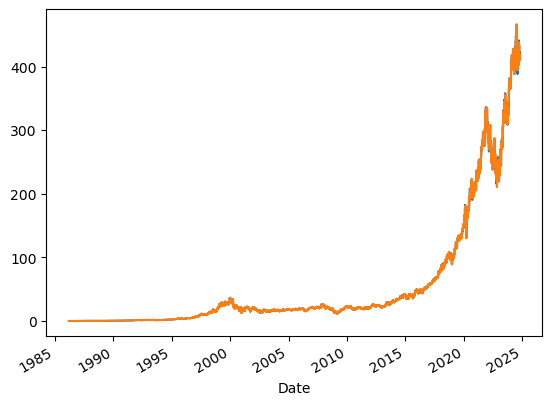

In [15]:
hist['Open'].plot()
hist['Close'].plot()
# hist['Dividends'].plot()
# hist['Stock Splits'].plot()

## Get Historical Stock Data

In [12]:
stock_list = ['MSFT', 
              "GOOG", 
              "NVDA", 
              "BRK.A",
              "AAPL", 
              "JPM",
              "AMZ", 
              "JNJ", 
              "GE", 
              "RTX",
              "PFE"]

In [13]:
hist = {}

for s in stock_list:
    tkr = yf.Tickers(s)
    history = tkr.history(period = "max")
    hist[s] = history
    

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))


KeyError: 'MSFT'